In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import nltk
import pickle
import numpy as np

#Preprocessing
from utils1 import pipeline_v1e
# nltk.download('punkt_tab')
from nltk.tokenize import PunktSentenceTokenizer


#Feature extraction
from sklearn.feature_extraction.text import CountVectorizer

#Sentiment Analysis with VADER
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentiment Analysis with TextBlob
# %pip install textblob
from textblob import TextBlob

#Regression Metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# %pip install wordcloud
from wordcloud import WordCloud

In [2]:
# data with transformer-based sentiment analysis
reviews_sentiment_label = pd.read_csv('reviews_sentiment_label.csv')

In [3]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   object 
 9   Sentiment_Score      9954 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 777.8+ KB


In [4]:
# labels into numbers - 'negative': 0, 'neutral': 1,'positive': 2
reviews_sentiment_label['Sentiment_Label'] = reviews_sentiment_label['Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [5]:
# to distinguish between Vader sentiment analysis and transformer-based sentiment analysis
reviews_sentiment_label.rename(columns={"Sentiment_Label": "Transformer_Sentiment_Label" , "Sentiment_Score": "Transformer_Sentiment_Score"}, inplace = True)

**VADER**

In [6]:
vader = SentimentIntensityAnalyzer()

In [7]:
#example
print(reviews_sentiment_label['Preprocessed_Review'].iloc[0])
print(vader.polarity_scores(reviews_sentiment_label['Review'].iloc[0]))

The ambience was good, food was quite good. had Saturday lunch, which was cost effective. Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.
{'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'compound': 0.9664}


In [8]:
reviews_compound_list = []
for review in reviews_sentiment_label['Review']:
    review_polarity = vader.polarity_scores(review)
    reviews_compound_list.append(review_polarity["compound"])

In [9]:
reviews_sentiment_label["VADER_Sentiment_Score"] = reviews_compound_list


The standard scoring metric followed by most of the analyzers:
- Positive sentiment: compound score >= 0.05
- Neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- Negative sentiment: compound score <= -0.05

In [10]:
reviews_sentiment_label["VADER_Sentiment_Label"] = list(map(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral",  reviews_sentiment_label["VADER_Sentiment_Score"]))

In [11]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Transformer_Sentiment_Label,Transformer_Sentiment_Score,VADER_Sentiment_Score,VADER_Sentiment_Label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,0.9664,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,0.9360,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,0.9186,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,0.8591,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,0.9201,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,2,0.870036,0.9923,positive
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,2,0.983094,0.9579,positive
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0,0.531457,0.9785,positive
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,2,0.982623,0.9359,positive


In [12]:
reviews_sentiment_label['VADER_Sentiment_Label'] = reviews_sentiment_label['VADER_Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [13]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [14]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Transformer_Sentiment_Label,Transformer_Sentiment_Score,VADER_Sentiment_Score,VADER_Sentiment_Label,Rating_label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,0.9664,2,2
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,0.9360,2,2
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,0.9186,2,2
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,0.8591,2,2
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,0.9201,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,2,0.870036,0.9923,2,1
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,2,0.983094,0.9579,2,2
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0,0.531457,0.9785,2,0
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,2,0.982623,0.9359,2,2


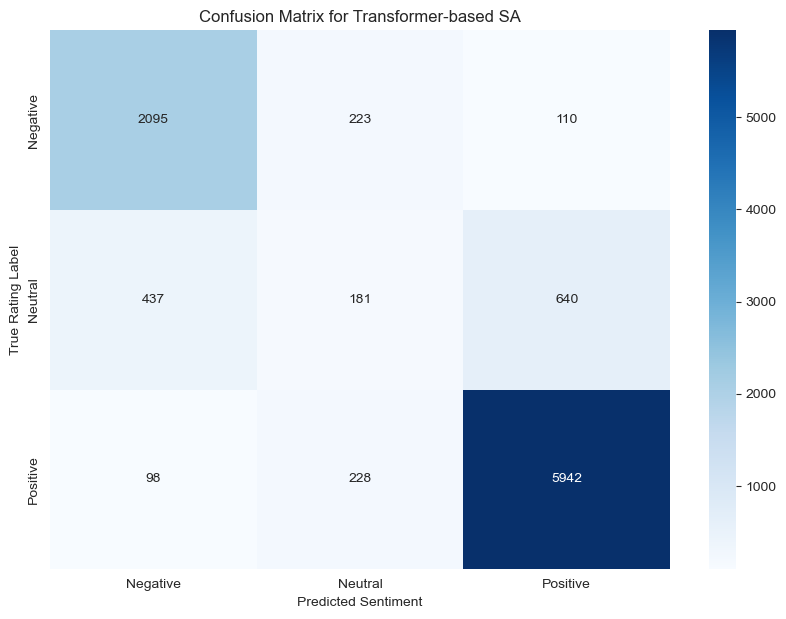

In [15]:
from sklearn.metrics import confusion_matrix

# confusion matrix TRANSFORMER
conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Transformer_Sentiment_Label'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for Transformer-based SA')
# plt.savefig("cf-transformer.jpg", format='jpg')
plt.show()

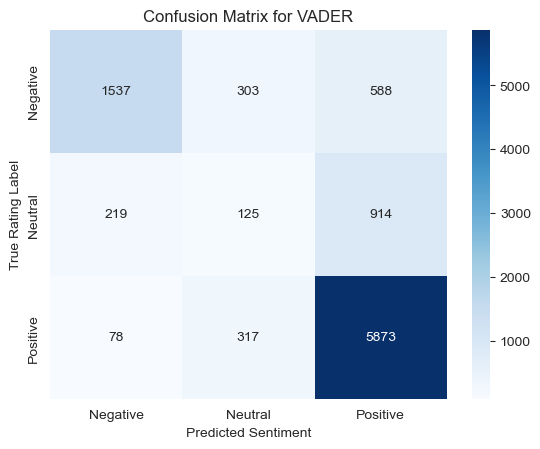

In [16]:
# confusion matrix VADER
conf_matrix2 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['VADER_Sentiment_Label'])
conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Transformer_Sentiment_Label'])

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for VADER')
# plt.savefig("cf-vader.jpg", format='jpg')
plt.show()


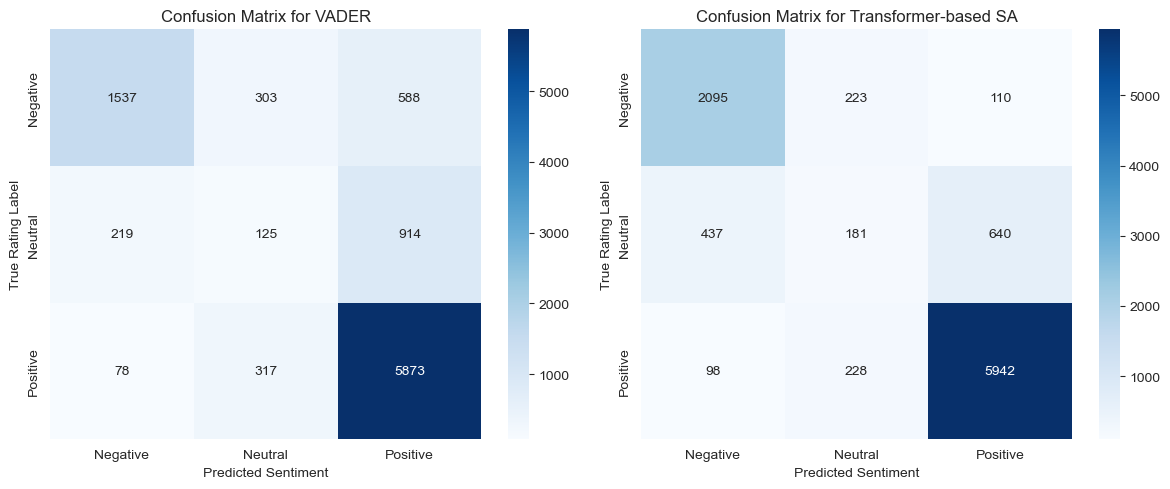

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for side-by-side comparison

# VADER Confusion Matrix
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('True Rating Label')
axes[0].set_title('Confusion Matrix for VADER')

# Transformer-based Confusion Matrix
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('True Rating Label')
axes[1].set_title('Confusion Matrix for Transformer-based SA')

# Adjust layout for readability
plt.tight_layout()
plt.savefig("cf-for-both.jpg")
plt.show()


In [18]:
accuracy_trans = round((conf_matrix1.trace()) / conf_matrix1.sum(), 2)
accuracy_vader = round((conf_matrix2.trace()) / conf_matrix2.sum(), 2)
print("accuracy for transformer:", accuracy_trans)
print("accuracy for vader:", accuracy_vader)

accuracy for transformer: 0.83
accuracy for vader: 0.76


In [29]:
from sklearn.metrics import classification_report

true_labels = reviews_sentiment_label['Rating_label']
predicted_labels_VADER = reviews_sentiment_label['VADER_Sentiment_Label']
predicted_labels_Transf = reviews_sentiment_label['Transformer_Sentiment_Label']

# report converted into dict to save it as csv
report_VADER = classification_report(true_labels, predicted_labels_VADER, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

report_Transf = classification_report(true_labels, predicted_labels_Transf, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# DataFrame
df_VADER = pd.DataFrame(report_VADER).transpose()
df_Transf = pd.DataFrame(report_Transf).transpose()

# saving to CSV
df_VADER.to_csv("classification_report_VADER.csv", index=True)
df_Transf.to_csv("classification_report_Transformer.csv", index=True)


In [30]:
df_VADER 

,precision,recall,f1-score,support
Negative,0.838059,0.633031,0.721258,2428.000000
Neutral,0.167785,0.099364,0.124813,1258.000000
Positive,0.796339,0.936981,0.860954,6268.000000
accuracy,0.756982,0.756982,0.756982,0.756982
macro avg,0.600728,0.556459,0.569008,9954.000000
weighted avg,0.727078,0.756982,0.733845,9954.000000


In [ ]:
# Normalized_rating = (rating - 3)/2
df_for_corr = reviews_sentiment_label[reviews_sentiment_label['Rating'] != 'Like']
df_for_corr['Normalized_rating'] = (df_for_corr['Rating'].astype(float) - 3) / 2

In [21]:
df_for_corr[["Review", "Normalized_rating", "VADER_Sentiment_Score"]]

,Review,Normalized_rating,VADER_Sentiment_Score
0,"The ambience was good, food was quite good . h...",1.00,0.9664
1,Ambience is too good for a pleasant evening. S...,1.00,0.9360
2,A must try.. great food great ambience. Thnx f...,1.00,0.9186
3,Soumen das and Arun was a great guy. Only beca...,1.00,0.8591
4,Food is good.we ordered Kodi drumsticks and ba...,1.00,0.9201
...,...,...,...
9949,Madhumathi Mahajan Well to start with nice cou...,0.00,0.9923
9950,This place has never disappointed us.. The foo...,0.75,0.9579
9951,"Bad rating is mainly because of ""Chicken Bone ...",-0.75,0.9785
9952,I personally love and prefer Chinese Food. Had...,0.50,0.9359


In [22]:
# Correlation between VADER sentiment score and rating 
corr_spearman = df_for_corr[['Normalized_rating', 'VADER_Sentiment_Score']].corr(method='spearman')
corr_pearson = df_for_corr[['Normalized_rating', 'VADER_Sentiment_Score']].corr(method='pearson')

print(f"Spearman correlation: {round(corr_spearman.iloc[0][1],2)}")
print(f"Pearson correlation: {round(corr_pearson.iloc[0][1],2)}")

Spearman correlation: 0.57
Pearson correlation: 0.7


In [23]:
df_for_corr["Normalized_rating"] = pd.to_numeric(df_for_corr["Normalized_rating"], errors="coerce")
df_for_corr["VADER_Sentiment_Score"] = pd.to_numeric(df_for_corr["VADER_Sentiment_Score"], errors="coerce")

#MSE - to check big diffrences between vader and rating score
df_for_corr["MSE"] = (df_for_corr["Normalized_rating"] - df_for_corr["VADER_Sentiment_Score"])**2

In [24]:
df_corr_sorted = df_for_corr.sort_values(by="MSE", ascending=False, )

In [28]:
df_corr_sorted[["Review", "Rating", 'VADER_Sentiment_Score', "MSE"]]

for _, row in df_corr_sorted.head(20).iterrows():  # `iterrows` zwraca indeks i dane wiersza
    print(f"Review: {row['Review']}")
    print(f"Rating: {row['Rating']}")
    print(f"Compound Score: {row['VADER_Sentiment_Score']}")
    print(f"MSE: {row['MSE']}")
    print("-" * 50)  # Separator między wierszami


Review: Fisherman's wharf used to be our fav joint when we lived in Goa. Excellent food and bevs.
Then we moved to Hyderabad, FMW followed.
We were so happy, to have a Goan restaurant just 5 min drive from home.
In the beginning it was great place to dine. Then it started getting local. Fishes started getting stale, fewer varieties ..Not so great.
Now , after about 3 years, it's more a typical curry point.
We ordered Mutton Xacuti and Kingfish Richado.
Fish was so firm and overcooked, richado overloaded with sweetness.
Mutton was out of the world, with heaps of Curry leaves(Kadi patta/Karia paku) , super high on heat....Reminded me of a Rayala curry in Dindi (Godavari distt ). Meat was cooked with extra affection that it took me 5 min to chew it like a bubblegum. I really thank myself for not ordering more.
Fisherman's wharf- such a disappointment.
Rating: 1.0
Compound Score: 0.9863
MSE: 3.94538769
--------------------------------------------------
Review: Zomato has asked me to be pol

In [33]:
df_corr_sorted[["Review", "Rating", "VADER_Sentiment_Score", "MSE"]]

,Review,Rating,VADER_Sentiment_Score,MSE
585,Fisherman's wharf used to be our fav joint whe...,1.0,0.9863,3.945388
7425,Zomato has asked me to be polite.. ok.. Faasos...,1.0,0.9816,3.926739
6140,It really been long time I have visited this p...,1.0,0.9737,3.895492
4514,"Place located just opposite of DLF gate no 3, ...",1.0,0.9671,3.869482
3701,A complete and absolute disaster. The place wh...,1.0,0.9598,3.840816
...,...,...,...,...
6382,very spicy,3.0,0.0000,0.000000
7579,food was not cooked....half fried chicken lolipop,3.0,0.0000,0.000000
6425,Decent place near DLF! Their fry piece chicken...,3.0,0.0000,0.000000
7540,average,3.0,0.0000,0.000000


In [36]:
# The highest MSE score
df_corr_sorted[["Review", "Rating", "VADER_Sentiment_Score", "MSE"]].loc[585]

Review                   Fisherman's wharf used to be our fav joint whe...
Rating                                                                 1.0
VADER_Sentiment_Score                                               0.9863
MSE                                                               3.945388
Name: 585, dtype: object